In [57]:
import pandas as pd
import json
import random
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
import numpy as np
import media_mapper as mm
from wordcloud import WordCloud
import ast
from string import punctuation
from nltk.corpus import stopwords
import re
import glob

In [58]:
def merge_shapes_with_dataframe(df):
    '''
    INPUT: A dataframe containing tweet data and the geoid
            for each tweet. 
            Merges dataframe with a csv containing the corresponding 
            shape file for each goid.
    OUPUT: A pandas dataframe containing the geoid and coordinates for each 
            neighborhood block in San Francisco.''' 
    
    ###Retrieve the Shape Files for Each Block:
    geo_df = pd.read_csv('/Users/christy/Documents/root/repos/media_mapper/data_pipeline/data/intermediate_data/sf_only_sql_shapes.csv')
    #format the dataframe
    geo_df['geoid10'] = geo_df.geoid10.astype('str')
    geo_df.drop('Unnamed: 0', axis = 1, inplace = True)

    df['geoid10'] =df['geoid10'].apply(lambda x: x[1:])
    #create a new dataframe 
    df = pd.merge(geo_df, df, on='geoid10', how='outer')
    return df

In [3]:
#GET A COUNT OF TWEETS EVERY HOUR OF EVERY DAY 
def get_tweets_per_hour(df):
    '''
    INPUT: a dataframe with tweets tagged with time information.
    OUTPUT: a transformed dataframe, where dataframe has been grouped
        to obtain the rate of tweets per hour for each day.
        Tokenized tweet text for every hour has been appended to one mater list.'''
    
    #set a count of tweets to determine tweet rate
    df['tweetcnt'] = 1
    #get a total count of tweets
    dfh = df.groupby(['geoid10','date', 'hour']).agg(sum).reset_index().drop('id', 1)
    #append the tokenized tweet data together
    d_txt = df.groupby(['geoid10', 'date','hour'])['text'].apply(lambda x: ','.join(x)).reset_index()
    #merge dataframes
    dfh['tokens'] = d_txt['text']
    dfh['tph'] = dfh['tweetcnt']
    dfh.drop('tweetcnt', 1, inplace = True)
    return dfh

In [59]:
def average_tweet_rate(df, date = False):
    '''
    INPUT: Dataframe with a date column, and average tweets per hour.
    OUPUT: Dataframe with the average tweets per hour.
            If date == True, return a dataframe with the average
            tweets for each day.
            If date == False, return a dataframe grouped over all dates.'''
    
    #get the average tweets per hour over days 
    df_date = df.groupby(['geoid10','date']).agg(np.mean).reset_index()
    #get a grouped sum of the words
    df_txt = df.groupby(['geoid10', 'date'])['tokens'].apply(lambda x: ','.join(x)).reset_index()
    #merge these two dataframes together
    df_date['tokens'] = df_txt['tokens']
    
    if date == True:
        return df_date
    
    else:
        dff = df_date.groupby(['geoid10']).agg(np.mean).reset_index()
        #get a grouped sum of the words
        dff_txt = df_date.groupby(['geoid10'])['tokens'].apply(lambda x: ','.join(x)).reset_index()
        #merge these two dataframes together
        dff['tokens'] = dff_txt['tokens']
        return dff



In [94]:
df = mm.pipeline.retrieve_and_merge_tweet_data()
df = mm.pipeline.transform_timestamp(df, hour = True)
dfh = get_tweets_per_hour(df)
dfr = average_tweet_rate(dfh)
#the list of tokens is inappropriate coded as a string. 
dfr['tokens'] = dfr['tokens'].apply(lambda x: ast.literal_eval(x)[0])

In [75]:
stop = stopwords.words('english')
stop.extend([p for p in punctuation])
stop.extend(['...',',,',',,,','..', 't','y','(@',')', 'c','i','I','a', '@','.', 'co', 'com','amp', 'via','http','htt','https', '()'])
stop =[unicode(word) for word in stop]

In [76]:
def remove_stopwords_and_links(token_row):
    if type(token_row) != list:
        token_row = [token_row]
    return [i.lower() for i in token_row if i.lower() not in stop]


In [63]:
def generate_wordcloud(df, outpath ='../../app/static/wrdcld/'):
    '''generates and saves a word cloud images corresponding to each neighborhood block.
    INPUT: dataframe containing tokens and geoid
    OUTPUT: saved .png image wordcloud'''
    
    #remove stopwords
    df['tokens'] = df['tokens'].apply(lambda x:remove_stopwords(x))
    #generate a word cloud from each row 
    for idx in df.index:
        label = str(df.geoid10[idx]) + '.png'
        tokens = df.tokens[idx]
        #don't generate a word cloud if there are no tokens.
        try:
            tokens = [re.sub(r'http.*$', '', item) for item in tokens]
            wordcloud = WordCloud(min_font_size = 6,font_step = 1,  \
                     background_color = 'white', scale= 1 ).generate(' '.join(tokens))
            plt.imshow(wordcloud)
            plt.axis("off")
            #plt.show()
            plt.savefig(outpath + label,  bbox_inches='tight')
        except:
            pass

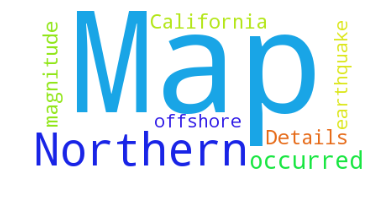

In [108]:
generate_wordcloud(dfr)

In [96]:
odd_ids = ['060750601001016', '060750179021003','060759901000003', '060759901000002', '060750179021000','060750601001000', '060759804011003', '060750201001001']
dfr = dfr[~dfr['geoid10'].isin(odd_ids)]
dfr['tph'] = dfr.tph.apply(lambda x: format(x, '.2f'))

In [97]:
dfr.head()

,geoid10,hour,tph,tokens
0,060750101001000,12.063492,1.30,"[And, I, think, to, my, self, what, a, wonderf..."
1,060750101001001,12.213758,2.86,"[These, guys, are, just, the, greatest, ., #sp..."
2,060750101001002,3.000000,1.00,Remember
3,060750101001004,11.497504,1.68,"[❤, ️, ❤, ️, ❤, ️, @, Fishermen's, Wharf, San,..."
4,060750101001005,10.375000,1.12,"[Seafood, stew, #latepost, #foodporn, @, Pompe..."


###B. Convert DataFrame of Conuts to Json File for Mapping

In [105]:
wordcloud_files = glob.glob( '../app/static/wrdcld/*png')

In [114]:
wordcloud_list = ['0' + word[21:-4] for word in wordcloud_files ]


In [117]:
dfr = dfr[dfr['geoid10'].isin(wordcloud_list)]

In [119]:
df = dfr.copy()

In [120]:
df = merge_shapes_with_dataframe(df)

In [121]:
df = df.dropna()

In [122]:
df.head()

,geometry,geoid10,hour,tph,tokens
5,"{""type"":""MultiPolygon"",""coordinates"":[[[[-122....",60750179021023,11.6,1.00,"[SF, ,, you're, such, a, babe, ., ❤, ️, @, Bay..."
6,"{""type"":""MultiPolygon"",""coordinates"":[[[[-122....",60750179021008,19.0,2.00,"[Two, lanes, blocked, in, #BayBridge, on, I-80..."
14,"{""type"":""MultiPolygon"",""coordinates"":[[[[-122....",60750179021057,13.0,1.00,"[raw, n, true]"
19,"{""type"":""MultiPolygon"",""coordinates"":[[[[-122....",60750179021054,0.0,1.00,@chrisjrn
26,"{""type"":""MultiPolygon"",""coordinates"":[[[[-122....",60750179021060,2.5,1.00,"[The, cool, ,, grey, city, of, love, ., #SF, @..."


In [51]:
def merge_shapes_with_dataframe(df):
    '''
    INPUT: pandas dataframe with a geoid column ('geoid10'). 
    OUTPUT: merges the current dataframe with the corresponding geographical
            coordinates for each neighborhood block in the 'geoid10' column.
            Returns the altered dataframe.'''

    ###retrieve the shape files for each block:
    geodf = pd.read_csv('data/intermediate_data/sf_only_sql_shapes.csv')
    #format the dataframe
    geodf['geoid10'] = geodf.geoid10.astype('str')
    geodf.drop('Unnamed: 0', axis = 1, inplace = True)
    df['geoid10'] =df['geoid10'].apply(lambda x: x[1:])
    
    #create a new dataframe 
    df = pd.merge(geodf, df, on='geoid10', how='outer')
    #drop empty hour columns
    return df

In [134]:
df.geoid10

5       60750179021023
6       60750179021008
14      60750179021057
19      60750179021054
26      60750179021060
35      60750179021058
47      60750179021031
49      60750179021006
66      60750179021079
73      60750179021030
78      60750179021063
93      60750179021032
100     60750179021041
106     60750179021040
119     60750179021043
125     60750231032015
127     60750179021018
128     60750231031003
141     60750231032013
143     60750179021066
146     60750231031000
150     60750179021034
157     60750179021001
159     60750231032007
163     60750231032006
170     60750231031007
171     60750232002015
178     60750231032017
184     60750231022005
185     60750232002012
             ...      
7318    60750352021008
7321    60750479021005
7323    60750604001013
7325    60750352013005
7326    60750479012013
7328    60750352014005
7329    60750352023005
7332    60750352022005
7333    60750479021007
7335    60750352021010
7339    60750352022006
7340    60750352021012
7343    607

In [139]:
def add_properties_geo(row):
    geoid = row['geoid10']
    tweetrate = row['tph']
    
    #image = "{{ url_for('static', filename='wrdcld/%s.png') }}" %(geoid)
    image = '../static/wrdcld/%s.png' %(geoid)
    geo_json = {"type": "Feature", "geometry": json.loads(row['geometry']),  "properties": {'image': image, 'geoid': geoid ,'tweetrate': tweetrate }}
    return geo_json

def dataframe_to_geojson(df, outfilename):
    '''Takes in a dataframe with a count and geoid10. Dumps it into a json geojason file'''
    df['geoid10'] = df['geoid10'].astype('str')
    df["tph"] = df['tph'].astype('str')
    list_to_export = []
    for idx, row in df.iterrows():
        list_to_export.append(add_properties_geo(row))
    with open(outfilename, 'w') as outfile:
        json.dump(list_to_export, outfile)

In [140]:
dataframe_to_geojson(df, '../app/data/wordcloud.json')

In [125]:
df.tph.unique()

array(['1.00', '2.00', '1.83', '1.10', '1.67', '1.30', '1.26', '1.07',
       '1.50', '1.03', '1.11', '1.36', '1.06', '1.47', '1.33', '1.12',
       '1.20', '3.25', '2.25', '1.56', '2.33', '1.28', '1.15', '2.19',
       '1.57', '1.25', '1.16', '5.11', '1.14', '2.89', '1.13', '2.30',
       '1.32', '1.80', '1.09', '1.08', '1.63', '1.17', '2.77', '1.27',
       '2.75', '1.29', '2.50', '3.00', '1.39', '1.04', '1.22', '1.24',
       '1.19', '1.23', '1.60', '2.67', '2.36', '1.31', '1.86', '2.80',
       '1.34', '2.92', '1.40', '1.05', '1.21', '1.02', '1.73', '2.05',
       '1.43', '2.01', '1.97', '1.18', '1.65', '2.10', '1.75', '1.53',
       '1.87', '1.42', '1.35', '1.52', '1.95', '4.00', '1.41', '1.61',
       '3.28', '2.24', '1.38', '1.93', '2.38', '2.83', '1.55', '1.66',
       '4.83', '1.45', '2.88', '1.62', '1.78', '1.49', '1.74', '1.68',
       '1.46', '6.18', '1.37', '1.70', '1.51', '1.72', '3.50', '1.94',
       '1.48', '2.20', '2.86', '1.71', '1.88', '2.07', '2.17', '2.40',
      